# Parse mutation data for time series, frequency plots.

## Problems & Solutions
### 1. Inconsistent number of columns in gdiff output files raises error with pandas read_table() function.
Solution 1: Use index.html output instead, parse into data structure acceptable by pandas.

In [179]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
soup = BeautifulSoup(open('/Users/ymseah/Documents/sic_UA3_S2_L001_breseq/output/index.html'), 'html5lib')

In [180]:
#EXAMPLE ROW
#<tr class="normal_table_row">
#<td align="center"><a href="evidence/INS_1.html">RA</a></td><!-- Evidence -->
#<td align="center">NC_002937</td><!-- Seq_Id -->
#<td align="right">42,867</td><!-- Position -->
#<td align="center">+G</td><!-- Cell Mutation -->
#<td align="right">100%</td>
#<td align="center">intergenic (‑125/+57)</td>
#<td align="center"><i>DVU0036</i> ← / ← <i>DVU0037</i></td>
#<td align="left">hypothetical protein/hypothetical protein</td>
#</tr>

#get each consensus mode row 
tr_consensus = soup('tr', 'normal_table_row')
cons_ref_genome = [tr.find_all_next('td')[1].text for tr in tr_consensus]
cons_mutation_pos = [tr.find_all_next('td')[2].text for tr in tr_consensus]
cons_mutation = [tr.find_all_next('td')[3].text for tr in tr_consensus]
cons_freq = [tr.find_all_next('td')[4].text for tr in tr_consensus]

#get each polymorphism mode row
tr_polymorphism = soup('tr', 'polymorphism_table_row')
polym_ref_genome = [tr.find_all_next('td')[1].text for tr in tr_polymorphism]
polym_mutation_pos = [tr.find_all_next('td')[2].text for tr in tr_polymorphism]
polym_mutation = [tr.find_all_next('td')[3].text for tr in tr_polymorphism]
polym_freq = [tr.find_all_next('td')[4].text for tr in tr_polymorphism]

ref_genome = cons_ref_genome + polym_ref_genome

mutation_pos = cons_mutation_pos + polym_mutation_pos
clean_mutation_pos = []
i = 0
while i < len(mutation_pos):
    clean_position = re.sub(',', '', mutation_pos[i])
    clean_mutation_pos.append(int(clean_position))
    i += 1

freq = cons_freq + polym_freq
clean_freqs = []
i = 0
while i < len(freq):
    clean_freq = re.sub('%', '', freq[i])
    clean_freqs.append(float(clean_freq))
    i += 1

mutation_freq_dict = {'genome': ref_genome, 'position': clean_mutation_pos, 'frequency': clean_freqs}

In [181]:
df = pd.DataFrame(mutation_freq_dict)
DvH = df.loc[df['genome'] == 'NC_002937']
#DvHplasmid = df.loc[df['genome'] == 'NC_005863']
MmS2 = df.loc[df['genome'] == 'NC_005791']

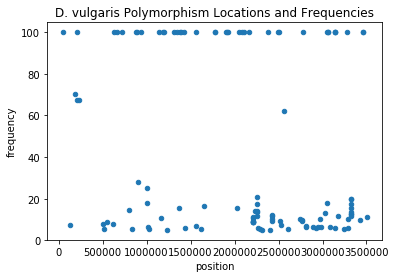

In [184]:
DvH.plot.scatter(x = 'position', y = 'frequency')
plt.title('D. vulgaris Polymorphism Locations and Frequencies')
plt.show()

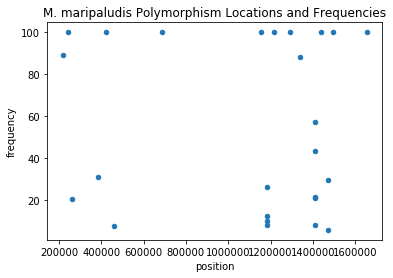

In [185]:
MmS2.plot.scatter(x = 'position', y = 'frequency')
plt.title('M. maripaludis Polymorphism Locations and Frequencies')
plt.show()